In [1]:
import torch
from tqdm import tqdm
import logging
import time
import scikitplot as skplt
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('Using CPU.')
    device = torch.device("cpu")

Using CPU.


/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [172]:
import numpy as np
import pandas as pd
tweet_train=pd.read_csv('train_proper.csv')
tweets = tweet_train.body
opinions = tweet_train.opinion

In [173]:
map_sentiment = {'irr' : 0, 'neu' : 1, 'pos' : 2, 'neg' : 3}
labels = opinions.apply(lambda x : map_sentiment[x])

In [174]:
import re

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(message) for message in tweets]

In [175]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    #logger.warn("Please specify option value between 1 and 4")
    return []

[nltk_data] Downloading package punkt to
[nltk_data]     /home_local/isduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home_local/isduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home_local/isduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


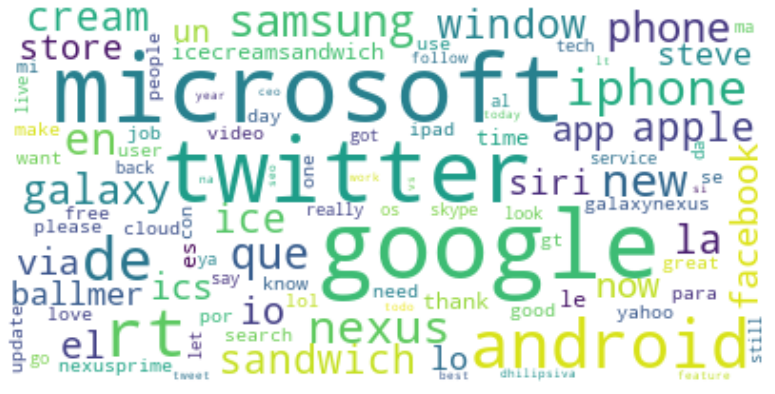

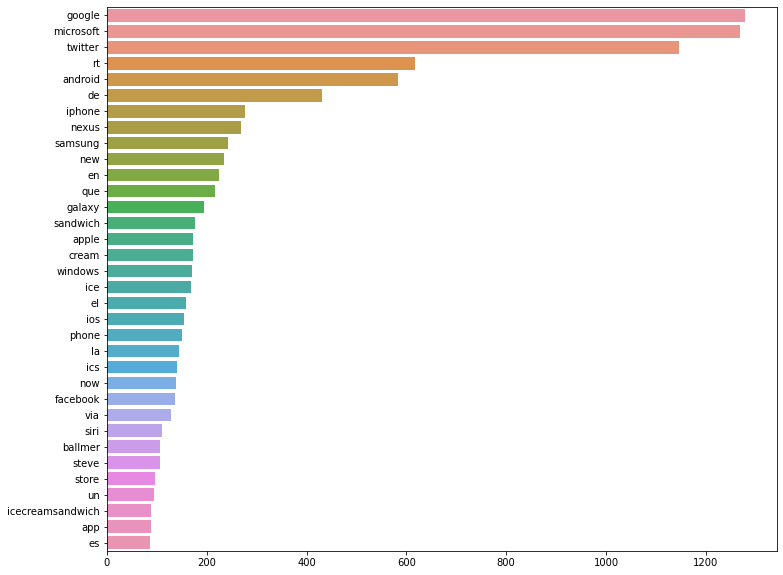

In [176]:
# Create vocab
import matplotlib.pyplot as plt
import seaborn as sns
def create_vocab(messages, show_graph=False):
    corpus = []
    for message in messages:
        tokens_1 = tokenize_text(message, 3) # Use option 3
        tokens = [x.lower() for x in tokens_1]
        corpus.extend(tokens)
    #logger.info("The number of all words: {}".format(len(corpus)))

    # Create Counter
    counts = Counter(corpus)
    #logger.info("The number of unique words: {}".format(len(counts)))

    # Create BoW
    bow = sorted(counts, key=counts.get, reverse=True)
    #logger.info("Top 40 frequent words: {}".format(bow[:40]))

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    if show_graph:
        from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
        # Generate Word Cloud image
        text = " ".join(corpus)
        stopwords = set(STOPWORDS)
        stopwords.update(["will", "report", "reporting", "market", "stock", "share"])

        wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(15,7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

        # Show most frequent words in a bar graph
        most = counts.most_common()[:80]
        x, y = [], []
        for word, count in most:
            if word not in stopwords:
                x.append(word)
                y.append(count)
        plt.figure(figsize=(12,10))
        sns.barplot(x=y, y=x)
        plt.show()

    return vocab

vocab= create_vocab(preprocessed, True)

In [178]:
from torch import nn

# Define LSTM Model
class LstmTextClassifier(nn.Module):
  def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
    """
    Initialize the model
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.lstm_size = lstm_size
    self.dense_size = dense_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers
    self.dropout = dropout

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
    self.dropout = nn.Dropout(dropout)
    # Insert an additional fully connected when combining with other inputs
    if dense_size == 0:
        self.fc = nn.Linear(lstm_size, output_size)
    else:
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    """
    Initialize the hidden state
    """
    weight = next(self.parameters()).data
    hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())

    return hidden

  def forward(self, nn_input_text, hidden_state):
    """
    Perform a forward pass of the model on nn_input
    """
    batch_size = nn_input_text.size(0)
    nn_input_text = nn_input_text.long()
    embeds = self.embedding(nn_input_text)
    lstm_out, hidden_state = self.lstm(embeds, hidden_state)
    # Stack up LSTM outputs, apply dropout
    lstm_out = lstm_out[-1,:,:]
    lstm_out = self.dropout(lstm_out)
    # Insert an additional fully connected when combining with other inputs
    if self.dense_size == 0:
        out = self.fc(lstm_out)
    else:
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
    # Softmax
    logps = self.softmax(out)

    return logps, hidden_state
      
     
# Define LSTM Tokenizer
def tokenizer_lstm(X, vocab, seq_len, padding):
  '''
  Returns tokenized tensor with left/right padding at the specified sequence length
  '''
  X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
  for i, text in enumerate(X):
    tokens_1 = tokenize_text(text, 3) 
    tokens = [x.lower() for x in tokens_1]
    token_ids = [vocab[word] for word in tokens]
    end_idx = min(len(token_ids), seq_len)
    if padding == 'right':
      X_tmp[i,:end_idx] = token_ids[:end_idx]
    elif padding == 'left':
      start_idx = max(seq_len - len(token_ids), 0)
      X_tmp[i,start_idx:] = token_ids[:end_idx]

  return torch.tensor(X_tmp, dtype=torch.int64)

In [179]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AutoModel, AutoTokenizer 
# Use pre-trained models for BERT
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#bert_model = AutoModel.from_pretrained("vinai/bertweet-base")

# For transformers v4.x+: 
#tokenizer_bert = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [180]:
from torch.utils.data import DataLoader, Dataset

# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
  def __init__(self, x, y):
    self.datalist=[(x[i], y[i]) for i in range(len(y))]
  def __len__(self):
    return len(self.datalist)
  def __getitem__(self,idx):
    return self.datalist[idx]
      
# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
  X_sampled = np.array(X, dtype=object)[indices]
  y_sampled = np.array(y)[indices].astype(int)
  dataset = SimpleDataset(X_sampled, y_sampled)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return loader

In [181]:
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
from torch.autograd import Variable

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip, log_level):
  result = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

  for n in num_samples:
    print("")
    logger.info("############### Start training for %d samples ###############" %n)

    # Stratified sampling
    train_size = n / len(y_all)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=train_size*0.2)
    train_indices, valid_indices = next(sss.split(X_all, y_all))

    # Sample input data
    train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
    valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

    if model_type == 'LSTM':
      model = LstmTextClassifier(len(vocab)+1, embed_size=512, lstm_size=1024, dense_size=0, output_size=5, lstm_layers=4, dropout=0.2)
      model.embedding.weight.data.uniform_(-1, 1)
    elif model_type == 'BERT':
      model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

    start_time = time.perf_counter() # use time.process_time() for CPU time
    acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level)
    end_time = time.perf_counter() # use time.process_time() for CPU time
    duration = end_time - start_time
    logger.info("Process Time (sec): {}".format(duration))
    result.loc[n] = (round(acc,4), round(f1,4), duration, duration/n*1000)

  return result, model_trained

# Define metrics
from sklearn.metrics import accuracy_score, f1_score

def metric(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  return acc, f1

In [182]:
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup

def train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level):
    # Set variables
    #logger = set_logger('sa_tweet_inperf', log_level)
    print("TRAIN LOADER", train_loader)
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.NLLLoss()

    # Set Train Mode
    model.train()

    # Initialise
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0
    class_names = ['0:Irrelevant','1:Neutral', '2:Positive', '3:Negative']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        logger.info('================     epoch {}     ==============='.format(epoch+1))

        #################### Training ####################
        # Initialise
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []
        hidden = model.init_hidden(batch_size) if model_type == "LSTM" else None

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch
            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
           
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            if model_type == "LSTM":
                # Tokenize the input and move to device
                text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Creating new variables for the hidden state to avoid backprop entire training history
                hidden = tuple([each.data for each in hidden])
                for each in hidden:
                    each.to(device)

                # Get output and hidden state from the model, calculate the loss
                logits, hidden = model(text_batch, hidden)
                loss = criterion(logits, labels)
                
            elif model_type == 'BERT':
                # Tokenize the input and move to device
                # Tokenizer Parameter
                param_tk = {
                    'return_tensors': "pt",
                    'padding': 'max_length',
                    'max_length': seq_len,
                    'add_special_tokens': True,
                    'truncation': True
                }
                text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                labels = torch.tensor(labels, dtype=torch.int64).to(device)

                # Feedforward prediction
                loss, logits = model(**text_batch, labels=labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()


            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # y_pred_tmp = np.zeros((len(y_valid), 5))
                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        if model_type == "LSTM":
                            # Tokenize the input and move to device
                            text_batch = tokenizer_lstm(text_batch, vocab, seq_len, padding='left').transpose(1,0).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)

                            # Creating new variables for the hidden state to avoid backprop entire training history
                            hidden = tuple([each.data for each in hidden])
                            for each in hidden:
                                each.to(device)

                            # Get output and hidden state from the model, calculate the loss
                            logits, hidden = model(text_batch, hidden)
                            loss = criterion(logits, labels)
                
                        elif model_type == 'BERT':
                            # Tokenize the input and move to device
                            text_batch = tokenizer_bert(text_batch, **param_tk).to(device)
                            labels = torch.tensor(labels, dtype=torch.int64).to(device)
                            # Feedforward prediction
                            loss, logits = model(**text_batch, labels=labels)
                    
                        loss_tmp += loss.item()
                        loss_cnt += 1

                        y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                        y_truth_tmp.extend(labels.cpu().numpy())
                        # logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))

                acc, f1 = metric(y_truth_tmp, y_pred_tmp)
                logger.debug("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}".format(epoch+1, epochs, steps, loss_tmp, acc, f1))
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        logger.info('Epoch: %d, Loss: %.4f, Acc: %.4f, F1: %.4f, LR: %.2e' % (epoch+1, loss_valid[-1], acc_valid[-1], f1_valid[-1], scheduler.get_last_lr()[0]))

        # Plot Confusion Matrix
        y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
        y_predicted_class = [class_names[int(idx)] for idx in y_pred_tmp]
        
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_truth_class, y_predicted_class, normalize=normalize, title=title, x_tick_rotation=75)
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return acc, f1, model

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

TRAIN LOADER <torch.utils.data.dataloader.DataLoader object at 0x7fa8d4d97ac8>


/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/pro

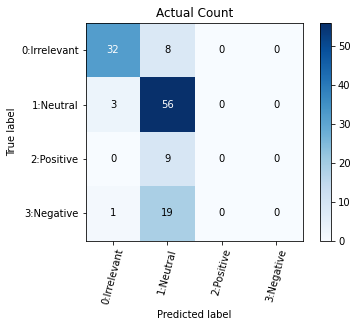

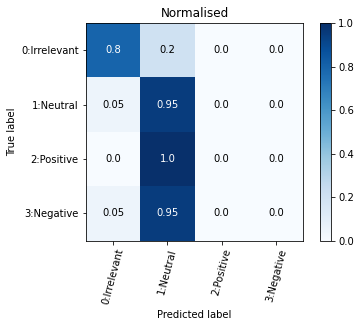

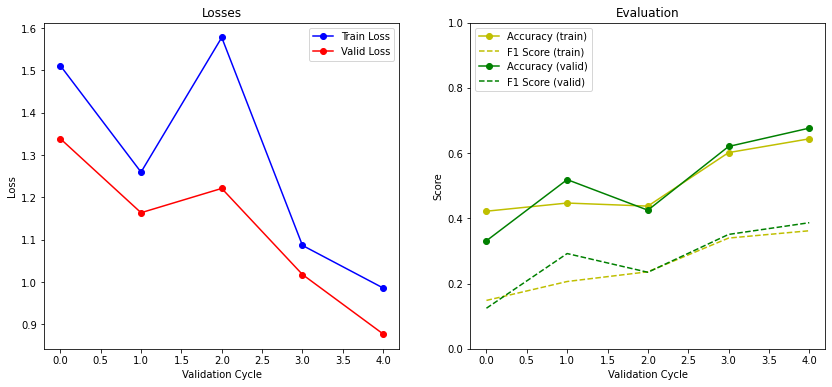

Epoch:  20%|██        | 1/5 [04:39<18:39, 279.80s/it]/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

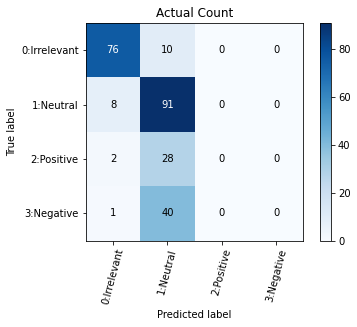

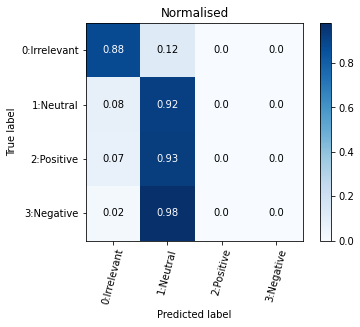

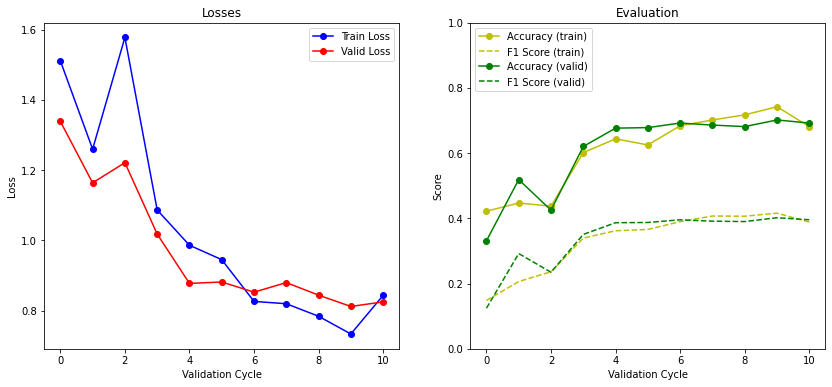

Epoch:  40%|████      | 2/5 [09:49<14:51, 297.10s/it]/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

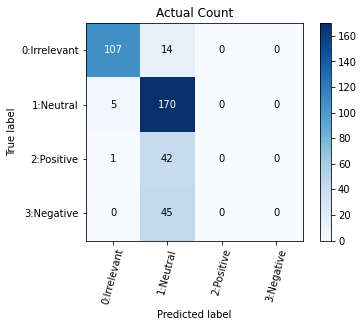

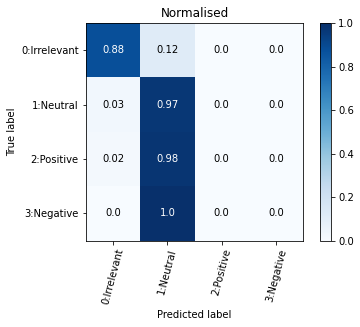

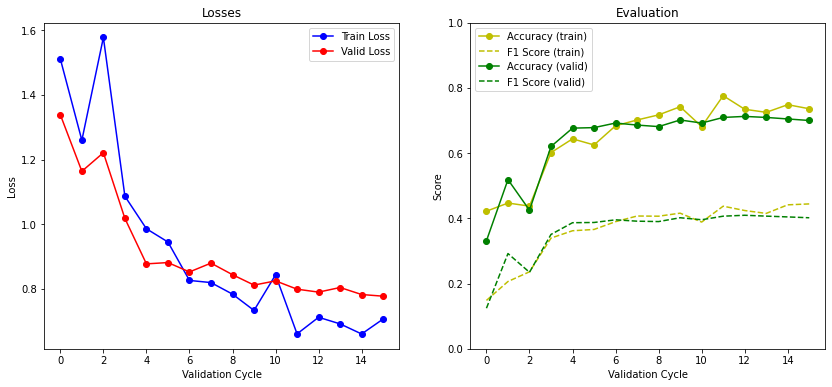

Epoch:  60%|██████    | 3/5 [14:35<09:44, 292.39s/it]/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

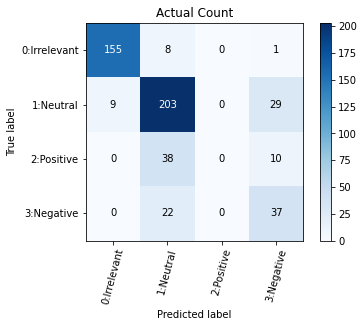

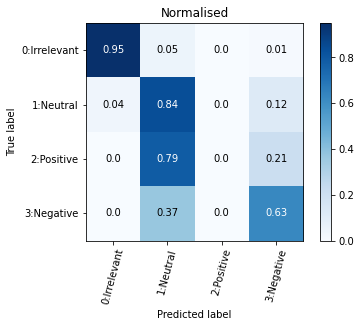

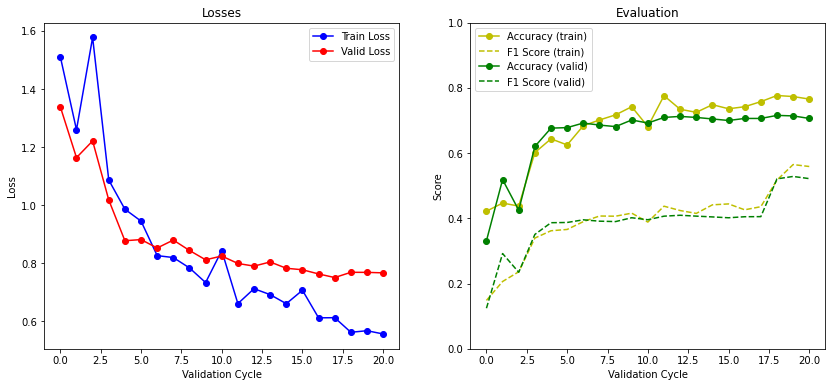

Epoch:  80%|████████  | 4/5 [18:52<04:38, 278.41s/it]/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home_local/isduser/Workspace/M2/projet-extraction-prog-stat-info/venv/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

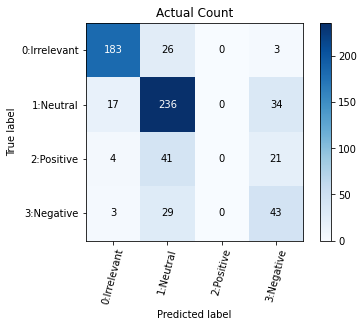

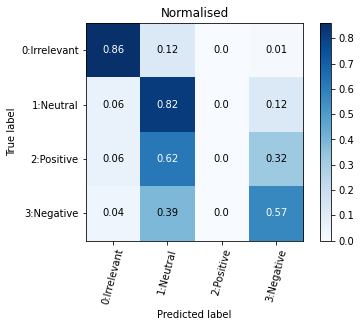

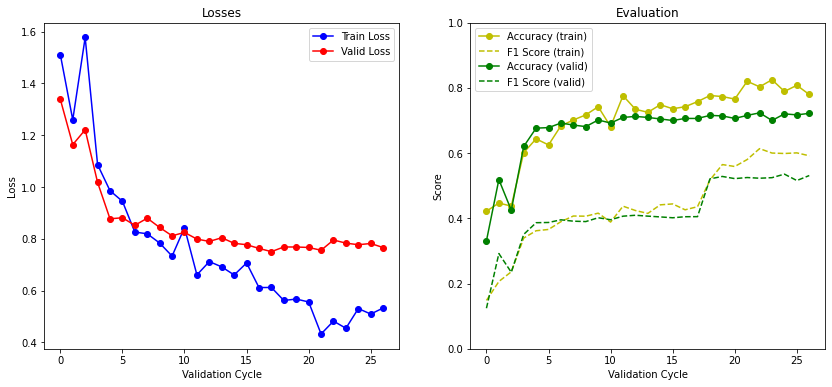

Epoch: 100%|██████████| 5/5 [23:14<00:00, 278.94s/it]


In [165]:
# Define the training parameters
#num_samples = [1000, 2000, 3000, 4000]
#epochs=5
num_samples = [3338]
epochs=5
patience=3
batch_size=64
seq_len = 30
lr=3e-4
clip=5
log_level=logging.DEBUG

# Run!
result_lstm, model_trained_lstm = train_cycles(preprocessed, labels, vocab, num_samples, 'LSTM', epochs, patience, batch_size, seq_len, lr, clip, log_level)

# Save the model and show the result
torch.save(model_trained_lstm.state_dict(), '../output' + 'stocktwit_lstm.dict')

In [167]:
result_lstm

,Accuracy,F1(macro),Total_Time,ms/text
3338,0.7219,0.5312,1394.72,417.832


In [183]:
# Define the training parameters
num_samples = [3338]
epochs=3
patience=3
batch_size=64
seq_len = 30
lr=2e-5
clip=1.0
log_level=logging.DEBUG

# Run!
result_bert, model_trained_bert = train_cycles(preprocessed, labels, vocab, num_samples, 'BERT', epochs, patience, batch_size, seq_len, lr, clip, log_level)

# Save the model and show the result
torch.save(model_trained_lstm.state_dict(), "../output" + 'stocktwit_bert.dict')
result_bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

TRAIN LOADER <torch.utils.data.dataloader.DataLoader object at 0x7fa8d4c01668>


Epoch:   0%|          | 0/3 [00:02<?, ?it/s]


AttributeError: 'str' object has no attribute 'softmax'